In [1]:
%load_ext autoreload
%matplotlib inline

# Isolation Forest Evaluation

In [2]:
import os, sys
import numpy as np
import pandas as pd
from IPython.display import display
sys.path.append(os.path.abspath(os.path.join('..')))

import plot.anomalies
from plot import pyplot as plt
from database.CERNMongoClient import CERNMongoClient
from anomaly_detection.IsolationForest import IsolationForest
from evaluation import evaluation, segmentation
from feature_extraction import feature_extraction, preprocessing

db = CERNMongoClient()

# auto-load changes in imported modules
%autoreload 2

In [3]:
B1_30 = feature_extraction.load_features_from_file("features_b1_sw-30min*")
B1_30_s = preprocessing.scale_robust(B1_30)

B2_30 = feature_extraction.load_features_from_file("features_b2_sw-30min*")
B2_30_s = preprocessing.scale_robust(B2_30)

Loading file '/home/n/master-thesis/src/../data-cern/features_b1_sw-30min*'.
File not found, loading '/home/n/master-thesis/src/../data-cern/features_b1_sw-30min_2018-02-26.csv' instead.
Loading file '/home/n/master-thesis/src/../data-cern/features_b2_sw-30min*'.
File not found, loading '/home/n/master-thesis/src/../data-cern/features_b2_sw-30min_2018-02-26.csv' instead.


In [4]:
labels_anomalies = db.query_elogbook_anomalies()
labels_all = db.query_elogbook()

Fetching data for pattern MKI.ELOGBOOK_tagged from 2016-04-16 00:00:00.000000 to 2016-09-14 00:00:00.000000
Fetching data for MKI.ELOGBOOK_tagged
Fetching data for pattern MKI.ELOGBOOK_tagged from 2016-04-16 00:00:00.000000 to 2016-09-14 00:00:00.000000
Fetching data for MKI.ELOGBOOK_tagged


## Evaluation

In [5]:
clf_b1 = IsolationForest(n_estimators=500, max_samples=256, contamination=0.1, n_jobs=-1, verbose=1)
b1_scored = clf_b1.fit_and_append_scores(B1_30_s)

clf_b2 = IsolationForest(n_estimators=500, max_samples=256, contamination=0.1, n_jobs=-1, verbose=1)
b2_scored = clf_b2.fit_and_append_scores(B2_30_s)

[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    6.1s remaining:    6.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    6.2s finished
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    5.7s remaining:    5.7s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    6.1s finished


In [6]:
amounts_of_anomalies = [200, 250, 500, 750, 1000, 2000]
segments_lists_B1 = list(segmentation.generate_multiple_segments(b1_scored, amounts_of_anomalies))
segments_lists_B2 = list(segmentation.generate_multiple_segments(b2_scored, amounts_of_anomalies))

In [7]:
label_counts = evaluation.count_labels(labels_all)
label_counts

/home/n/master-thesis/src/evaluation/evaluation.py:109: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  label_totals.sortlevel([0, 1], ascending=True, inplace=True)


labels
BEAM TAG                 
1    anomaly            9
     fault              4
     info              26
     intervention       9
     research           1
2    anomaly            7
     fault             11
     info              21
     intervention      10
     research           2

In [9]:
all_prediction_stats = []

for amount_of_anomalies, segment_B1, segment_B2 in zip(amounts_of_anomalies, segments_lists_B1, segments_lists_B2):
    stats = evaluation.count_predictions_precision_recall(labels_all, segment_B1, segment_B2)
    all_prediction_stats.append(stats)
    
    table = evaluation.labels_vs_segments_beams(labels_anomalies, segment_B1, segment_B2)
    
    evaluation.print_labels_vs_segments_stats(amount_of_anomalies, segment_B1, segment_B2, table)
    display(evaluation.apply_style_labels_vs_segments(table))
    display(stats)

/home/n/master-thesis/src/evaluation/evaluation.py:109: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  label_totals.sortlevel([0, 1], ascending=True, inplace=True)
/home/n/master-thesis/src/evaluation/evaluation.py:163: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  table.sortlevel([0, 1], ascending=True, inplace=True)


Anomalies used: 200
Anomalies in segments for B1: 200
Anomalies in segments for B2: 200
Segments in B1: 73
Segments in B2: 60
Segments for B1 that lie near anomaly labels:  4.0
Segments for B2 that lie near anomaly labels:  4.0
Anomalies in segments for B1 that lie near anomaly labels:  10.0
Anomalies in segments for B2 that lie near anomaly labels:  17.0


labels  predictions near labels  predictions  precision  \
BEAM TAG                                                                     
1    anomaly            9                      3.0         73.0   0.219178   
     fault              4                      2.0          0.0   0.000000   
     info              26                     10.0          0.0   0.000000   
     intervention       9                      0.0          0.0   0.000000   
     research           1                      1.0          0.0   0.000000   
2    anomaly            7                      2.0         60.0   0.216667   
     fault             11                      2.0          0.0   0.000000   
     info              21                      8.0          0.0   0.000000   
     intervention      10                      1.0          0.0   0.000000   
     research           2                      0.0          0.0   0.000000   

                     recall  
BEAM TAG                     
1    anomaly       0.333333  
     fault         0.500000  
     info          0.384615  
     intervention  0.000000  
     research      1.000000  
2    anomaly       0.285714  
     fault         0.181818  
     info          0.380952  
     intervention  0.100000  
     research      0.000000

Anomalies used: 250
Anomalies in segments for B1: 249
Anomalies in segments for B2: 250
Segments in B1: 80
Segments in B2: 76
Segments for B1 that lie near anomaly labels:  5.0
Segments for B2 that lie near anomaly labels:  5.0
Anomalies in segments for B1 that lie near anomaly labels:  11.0
Anomalies in segments for B2 that lie near anomaly labels:  19.0


labels  predictions near labels  predictions  precision  \
BEAM TAG                                                                     
1    anomaly            9                      3.0         80.0   0.212500   
     fault              4                      3.0          0.0   0.000000   
     info              26                     10.0          0.0   0.000000   
     intervention       9                      0.0          0.0   0.000000   
     research           1                      1.0          0.0   0.000000   
2    anomaly            7                      3.0         76.0   0.210526   
     fault             11                      4.0          0.0   0.000000   
     info              21                      8.0          0.0   0.000000   
     intervention      10                      1.0          0.0   0.000000   
     research           2                      0.0          0.0   0.000000   

                     recall  
BEAM TAG                     
1    anomaly       0.333333  
     fault         0.750000  
     info          0.384615  
     intervention  0.000000  
     research      1.000000  
2    anomaly       0.428571  
     fault         0.363636  
     info          0.380952  
     intervention  0.100000  
     research      0.000000

Anomalies used: 500
Anomalies in segments for B1: 487
Anomalies in segments for B2: 494
Segments in B1: 100
Segments in B2: 100
Segments for B1 that lie near anomaly labels:  10.0
Segments for B2 that lie near anomaly labels:  8.0
Anomalies in segments for B1 that lie near anomaly labels:  54.0
Anomalies in segments for B2 that lie near anomaly labels:  65.0


labels  predictions near labels  predictions  precision  \
BEAM TAG                                                                     
1    anomaly            9                      5.0        100.0       0.23   
     fault              4                      3.0          0.0       0.00   
     info              26                     13.0          0.0       0.00   
     intervention       9                      1.0          0.0       0.00   
     research           1                      1.0          0.0       0.00   
2    anomaly            7                      4.0        100.0       0.18   
     fault             11                      4.0          0.0       0.00   
     info              21                      9.0          0.0       0.00   
     intervention      10                      1.0          0.0       0.00   
     research           2                      0.0          0.0       0.00   

                     recall  
BEAM TAG                     
1    anomaly       0.555556  
     fault         0.750000  
     info          0.500000  
     intervention  0.111111  
     research      1.000000  
2    anomaly       0.571429  
     fault         0.363636  
     info          0.428571  
     intervention  0.100000  
     research      0.000000

Anomalies used: 750
Anomalies in segments for B1: 728
Anomalies in segments for B2: 735
Segments in B1: 106
Segments in B2: 109
Segments for B1 that lie near anomaly labels:  10.0
Segments for B2 that lie near anomaly labels:  11.0
Anomalies in segments for B1 that lie near anomaly labels:  91.0
Anomalies in segments for B2 that lie near anomaly labels:  120.0


labels  predictions near labels  predictions  precision  \
BEAM TAG                                                                     
1    anomaly            9                        5          106   0.216981   
     fault              4                        3            0   0.000000   
     info              26                       13            0   0.000000   
     intervention       9                        1            0   0.000000   
     research           1                        1            0   0.000000   
2    anomaly            7                        4          109   0.174312   
     fault             11                        4            0   0.000000   
     info              21                        9            0   0.000000   
     intervention      10                        1            0   0.000000   
     research           2                        1            0   0.000000   

                     recall  
BEAM TAG                     
1    anomaly       0.555556  
     fault         0.750000  
     info          0.500000  
     intervention  0.111111  
     research      1.000000  
2    anomaly       0.571429  
     fault         0.363636  
     info          0.428571  
     intervention  0.100000  
     research      0.500000

Anomalies used: 1000
Anomalies in segments for B1: 963
Anomalies in segments for B2: 980
Segments in B1: 110
Segments in B2: 112
Segments for B1 that lie near anomaly labels:  10.0
Segments for B2 that lie near anomaly labels:  11.0
Anomalies in segments for B1 that lie near anomaly labels:  133.0
Anomalies in segments for B2 that lie near anomaly labels:  184.0


labels  predictions near labels  predictions  precision  \
BEAM TAG                                                                     
1    anomaly            9                        5          110   0.209091   
     fault              4                        3            0   0.000000   
     info              26                       13            0   0.000000   
     intervention       9                        1            0   0.000000   
     research           1                        1            0   0.000000   
2    anomaly            7                        4          112   0.178571   
     fault             11                        4            0   0.000000   
     info              21                       10            0   0.000000   
     intervention      10                        1            0   0.000000   
     research           2                        1            0   0.000000   

                     recall  
BEAM TAG                     
1    anomaly       0.555556  
     fault         0.750000  
     info          0.500000  
     intervention  0.111111  
     research      1.000000  
2    anomaly       0.571429  
     fault         0.363636  
     info          0.476190  
     intervention  0.100000  
     research      0.500000

Anomalies used: 2000
Anomalies in segments for B1: 1923
Anomalies in segments for B2: 1939
Segments in B1: 116
Segments in B2: 119
Segments for B1 that lie near anomaly labels:  12.0
Segments for B2 that lie near anomaly labels:  13.0
Anomalies in segments for B1 that lie near anomaly labels:  310.0
Anomalies in segments for B2 that lie near anomaly labels:  374.0


labels  predictions near labels  predictions  precision  \
BEAM TAG                                                                     
1    anomaly            9                        5          116   0.206897   
     fault              4                        3            0   0.000000   
     info              26                       13            0   0.000000   
     intervention       9                        2            0   0.000000   
     research           1                        1            0   0.000000   
2    anomaly            7                        6          119   0.193277   
     fault             11                        4            0   0.000000   
     info              21                       10            0   0.000000   
     intervention      10                        2            0   0.000000   
     research           2                        1            0   0.000000   

                     recall  
BEAM TAG                     
1    anomaly       0.555556  
     fault         0.750000  
     info          0.500000  
     intervention  0.222222  
     research      1.000000  
2    anomaly       0.857143  
     fault         0.363636  
     info          0.476190  
     intervention  0.200000  
     research      0.500000

In [10]:
stats = evaluation.summary_precision_recall_df(all_prediction_stats, amounts_of_anomalies, "amounts of anomalies")
evaluation.apply_style_precision_recall(stats)

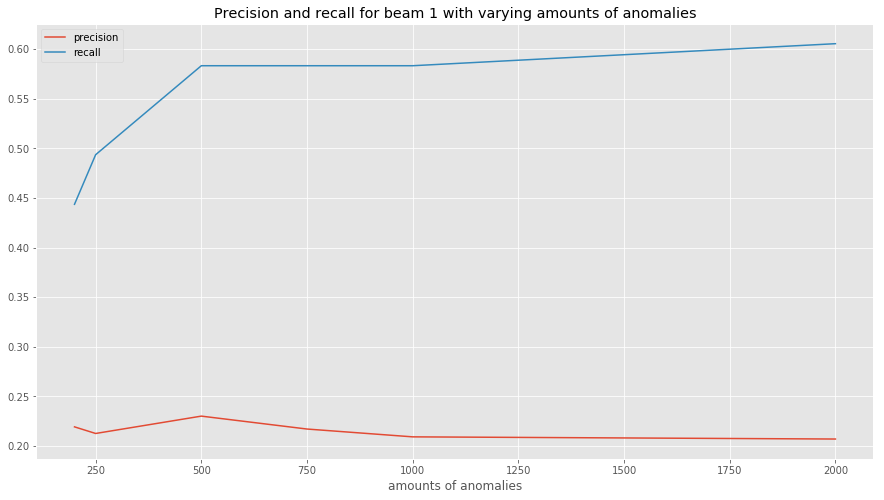

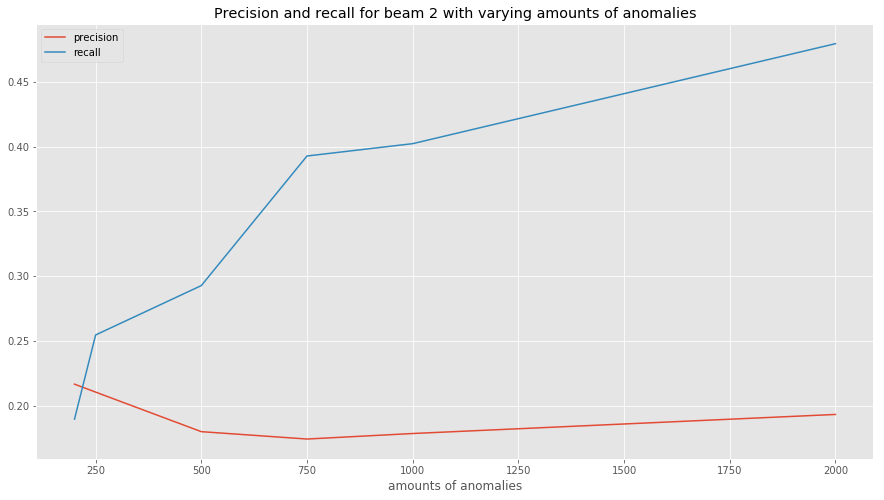

In [11]:
plot.anomalies.precision_recall_stats(stats, "amounts of anomalies")

## Visualization

In [12]:
labels_anomalies_B1 = db.query_elogbook_anomalies(beam=1)
labels_anomalies_B2 = db.query_elogbook_anomalies(beam=2)

labels_no_info_B1 = db.query_elogbook_no_info(beam=1)
labels_no_info_B2 = db.query_elogbook_no_info(beam=2)

Fetching data for pattern MKI.ELOGBOOK_tagged from 2016-04-16 00:00:00.000000 to 2016-09-14 00:00:00.000000
Fetching data for MKI.ELOGBOOK_tagged
Fetching data for pattern MKI.ELOGBOOK_tagged from 2016-04-16 00:00:00.000000 to 2016-09-14 00:00:00.000000
Fetching data for MKI.ELOGBOOK_tagged
Fetching data for pattern MKI.ELOGBOOK_tagged from 2016-04-16 00:00:00.000000 to 2016-09-14 00:00:00.000000
Fetching data for MKI.ELOGBOOK_tagged
Fetching data for pattern MKI.ELOGBOOK_tagged from 2016-04-16 00:00:00.000000 to 2016-09-14 00:00:00.000000
Fetching data for MKI.ELOGBOOK_tagged


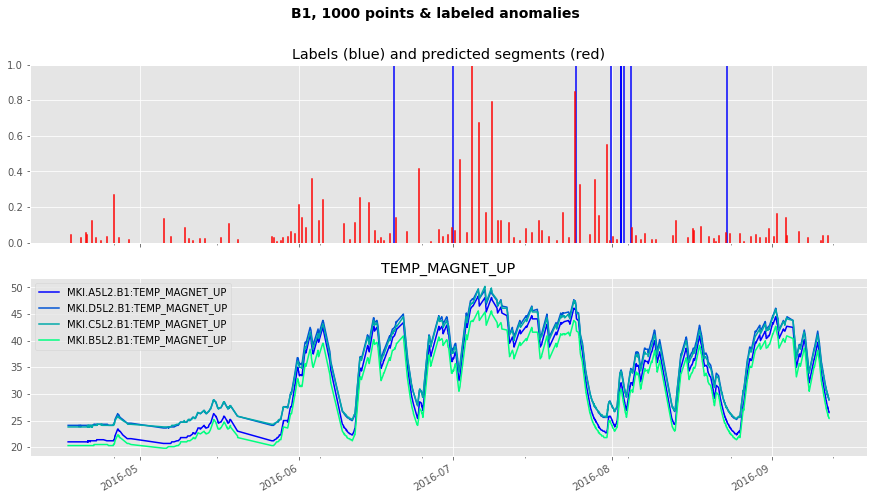

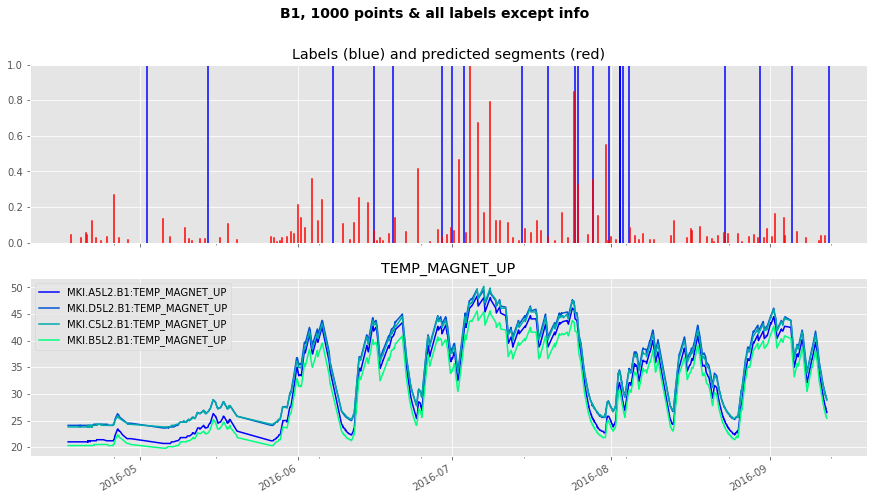

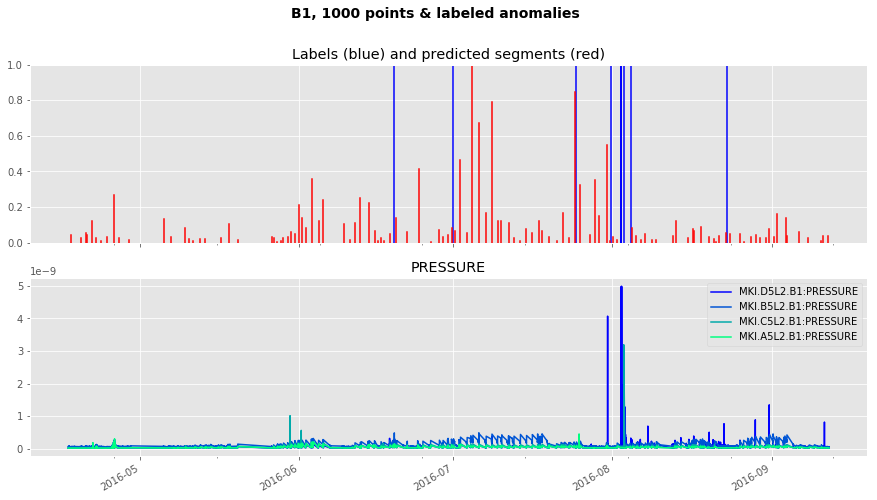

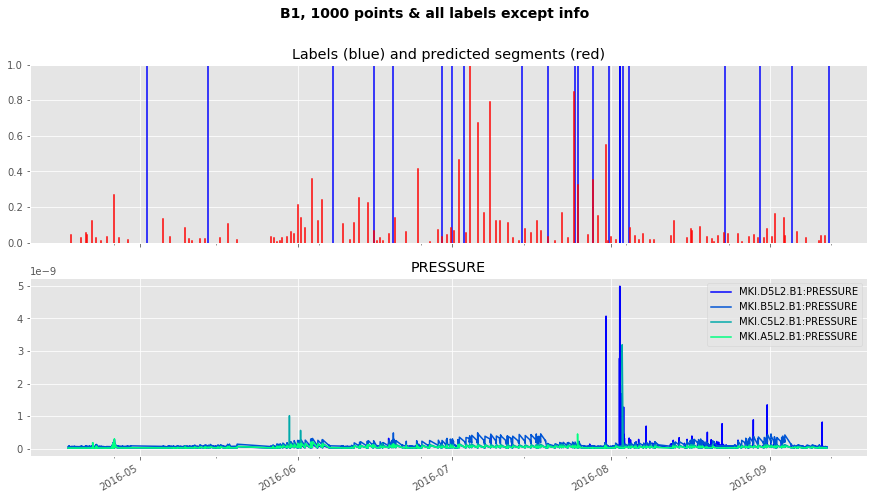

In [13]:
plot.anomalies.timeseries_segments(B1_30, "TEMP_MAGNET_UP", segments_lists_B1[-1], labels_anomalies_B1, 'B1, 1000 points & labeled anomalies')
plot.anomalies.timeseries_segments(B1_30, "TEMP_MAGNET_UP", segments_lists_B1[-1], labels_no_info_B1, 'B1, 1000 points & all labels except info')

plot.anomalies.timeseries_segments(B1_30, "PRESSURE", segments_lists_B1[-1], labels_anomalies_B1, 'B1, 1000 points & labeled anomalies')
plot.anomalies.timeseries_segments(B1_30, "PRESSURE", segments_lists_B1[-1], labels_no_info_B1, 'B1, 1000 points & all labels except info')

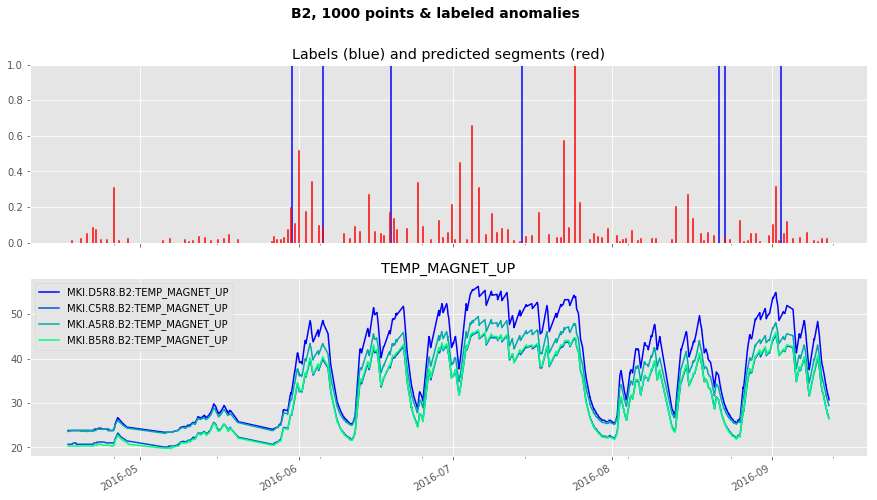

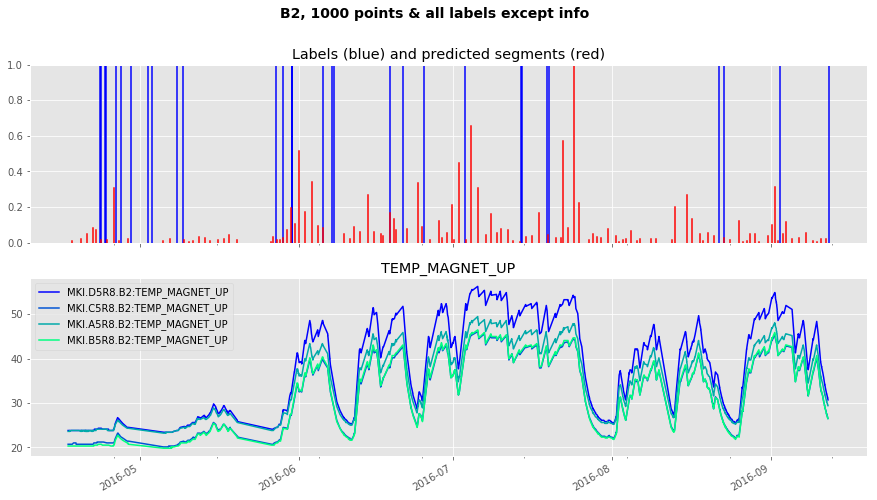

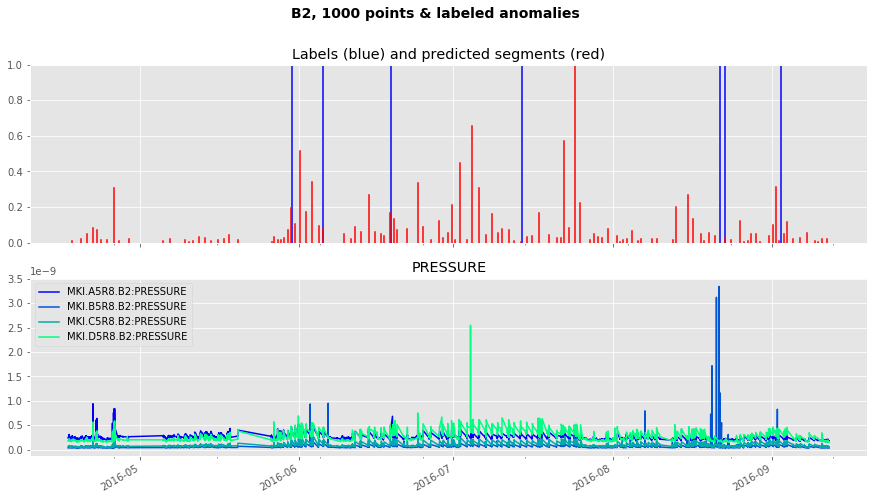

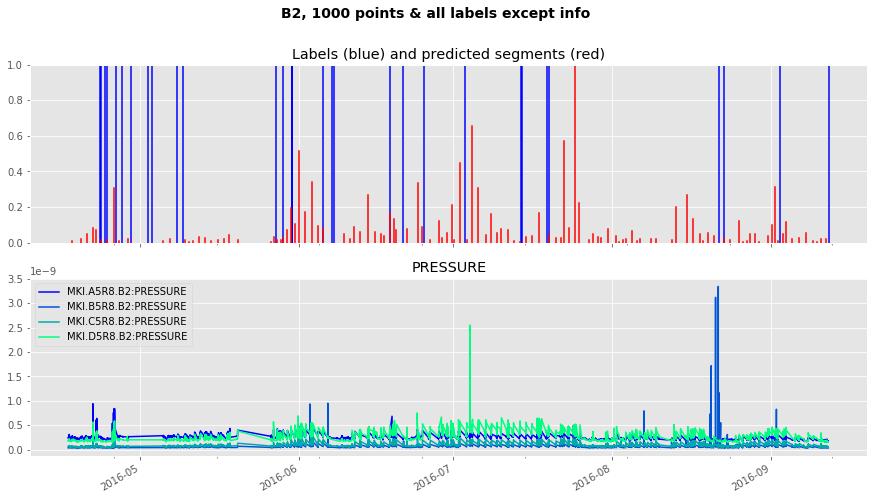

In [14]:
plot.anomalies.timeseries_segments(B2_30, "TEMP_MAGNET_UP", segments_lists_B2[-1], labels_anomalies_B2, 'B2, 1000 points & labeled anomalies')
plot.anomalies.timeseries_segments(B2_30, "TEMP_MAGNET_UP", segments_lists_B2[-1], labels_no_info_B2, 'B2, 1000 points & all labels except info')

plot.anomalies.timeseries_segments(B2_30, "PRESSURE", segments_lists_B2[-1], labels_anomalies_B2, 'B2, 1000 points & labeled anomalies')
plot.anomalies.timeseries_segments(B2_30, "PRESSURE", segments_lists_B2[-1], labels_no_info_B2, 'B2, 1000 points & all labels except info')